# Sentiment Analysis - Project

## 1. Import libraries

In [7]:
!pip install contractions

# Preprocess data
import re
import string
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

# Visualize data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Split data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Train data
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Load data

In [8]:
df = pd.read_csv("/content/IMDB-Dataset.csv")
df = df.drop_duplicates()

In [9]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 3. Preprocess the data

In [11]:
# Expanding contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to clean data
def preprocess_text(text):

    wl = WordNetLemmatizer()

    soup = BeautifulSoup(text , "html.parser") # Removing html tags
    text = soup.get_text()
    text = expand_contractions(text) # Expanding chatwords and contracts clearing contractions
    emoji_clean = re.compile("["
                            u"\U0001F600-\U0001F64F" # emoticons
                            u"\U0001F300-\U0001F5FF" # symbols & pictographs
                            u"\U0001F680-\U0001F6FF" # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags = re.UNICODE)
    text = emoji_clean.sub(r"", text)
    text = re.sub(r"\.(?=\ S)", ". ", text) # add space after full stop
    text = re.sub(r"http\S+", "", text) # remove urls
    text = "". join([word.lower() for word in text if word not in string.punctuation]) # remove punctuation and make text lowercase

    stop = set(stopwords.words("english"))
    text = " ". join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) # lemmatize

    return text

In [12]:
df["review"] = df["review"].apply(preprocess_text)

<ipython-input-11-a8e1ae47a8be>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text , "html.parser") # Removing html tags


In [14]:
df["review"][0]

'one reviewer mentioned watching oz episode hooked right exactly happened methe first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda city home manyaryans muslim gangsta latino christian italian irish moreso scuffle death stare dodgy dealing shady agreement never far awayi would say main appeal show due fact go show would dare forget pretty picture painted mainstream audience forget charm forget romanceoz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison 

## 4. Visualize the data

In [20]:
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def create_pie_chart(data):
    pie, ax = plt.subplots(figsize = [11, 7])
    plt.pie(x = data, autopct = lambda pct: func(pct, data), explode = [0.0025] * 2, pctdistance = 0.5, colors = [sns.color_palette()[0], "tab:red"],
            textprops = {"fontsize": 16})
    plt.title("Frequencies of sentiment labels", fontsize = 14, fontweight = "bold")
    labels = [r"Positive", r"Negative"]
    plt.legend(labels, loc = "best", prop = {"size": 14})
    pie.savefig("PieChart.png")
    plt.show()

def create_histograms(df):
    hist_positive = sns.displot(data = df[df["sentiment"] == "positive"], x = "words length", hue = "sentiment",
                            kde = True, height = 7, aspect = 1.1, legend = False).set(title = "Words in positive reviews")
    plt.show(hist_positive)

    hist_negative = sns.displot(data = df[df["sentiment"] == "negative"], x = "words length", hue = "sentiment",
                                kde = True, height = 7, aspect = 1.1, legend = False , palette = ["red"]).set(title = "Words in negative reviews")
    plt.show(hist_negative)

    plt.figure(figsize = (7, 7.1))
    kernel_distibution_number_words_plot = sns.kdeplot(data = df, x = "words length", hue = "sentiment", fill = True,
                                                      palette = [sns.color_palette()[0], "red"]).set(title = "Words in reviews")
    plt.legend(title = "Sentiment", labels = ["negative", "positive"])
    plt.show(kernel_distibution_number_words_plot)

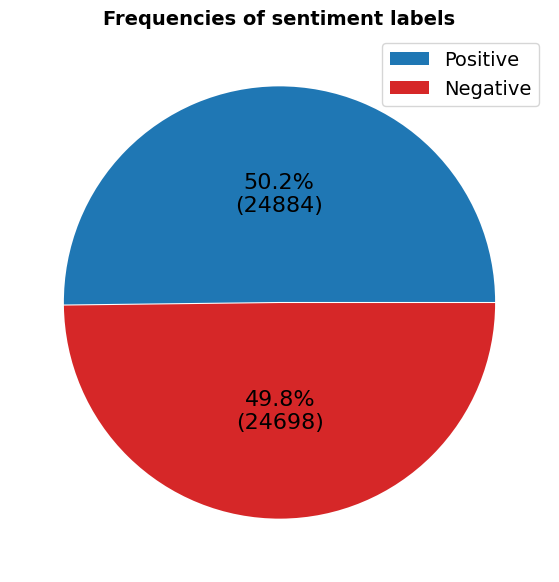

In [22]:
freq_pos = len(df[df["sentiment"] == "positive"])
freq_neg = len(df[df["sentiment"] == "negative"])
data = [freq_pos, freq_neg]
create_pie_chart(data)

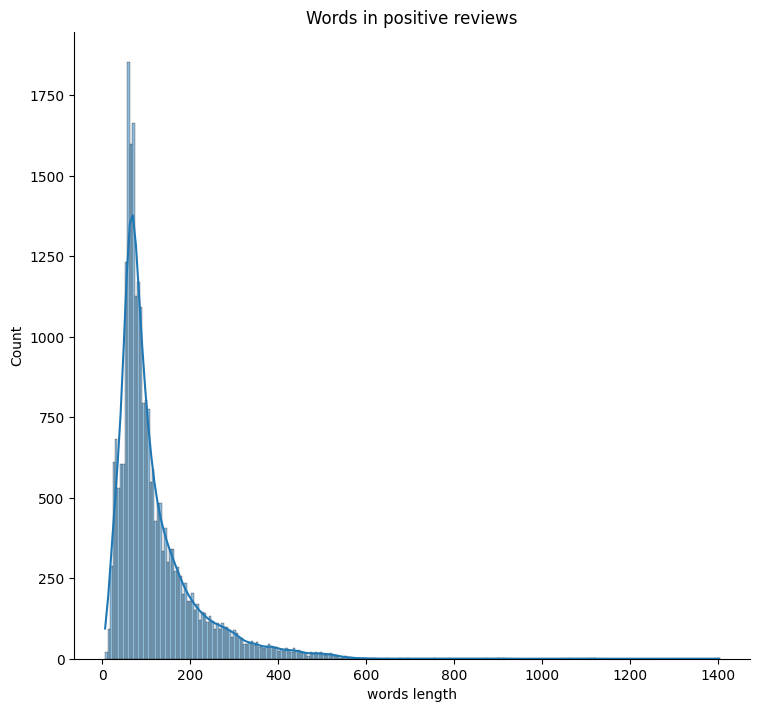

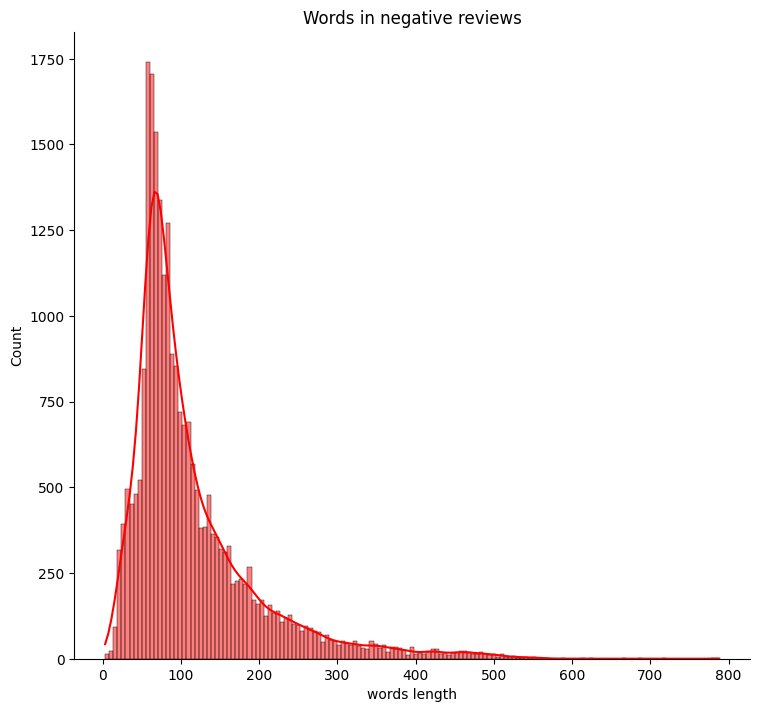

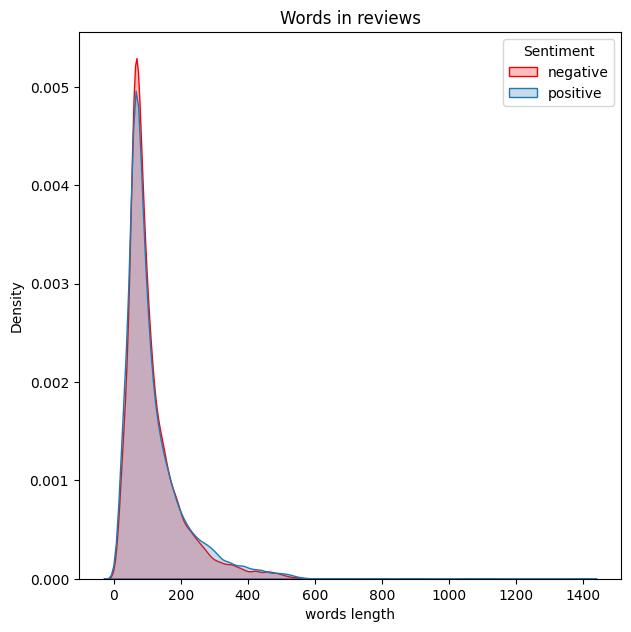

In [23]:
words_len = df["review"].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp["words length"] = words_len
create_histograms(df_temp)

## 5. Split train, test dataset

In [24]:
x_data = df["review"].copy()

label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df["sentiment"])

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 42)

## 6. Convert data to vector

In [25]:
tfidf_vectorizer = TfidfVectorizer(max_features = 10000)
tfidf_vectorizer.fit(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

## 7. Train and evaluate the data

In [26]:
dt_classifier = DecisionTreeClassifier(criterion = "entropy", random_state = 42)
dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.7093879197337905

In [27]:
rf_classifier = RandomForestClassifier(random_state = 42)
rf_classifier.fit(x_train_encoded, y_train)
y_pred = rf_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.8408792981748513